In [319]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

The goal of this code is to generate a polynomial with given combinatorics. Using principles from Teichmüller theory, one can prove the convergence of this algorithm to the desired polynomial.

Throughout the documentation, we use 'rational angle' to refer to an element of $\mathbb{Q}/\mathbb{Z}$ and may omit the implicit multiple of $2\pi$ where appropriate.


The underlying math comes from this paper by John Hubbard and Dierk Schleicher https://pi.math.cornell.edu/~hubbard/SpidersFinal.pdf.
This implementation is by Jeffrey Lantz and Riley Guyett.

In [320]:
FLOAT_ERR = math.pow(10,-7)
# Returns True if the three points are clockwise oriented
# Note: False if collinear
def orient(z1, z2, z3):
    return (z2.imag-z1.imag)*(z3.real-z2.real) > (z2.real-z1.real)*(z3.imag-z2.imag)

# Returns True iff seg1 intersects seg2
# seg1 and seg2 are numpy arrays of two complex points
def intersect_segs(seg1,seg2):
    # Non-collinear segments ab and cd intersect iff o(abc) != o(abd) and o(cda) != o(cdb)
    o1= orient(seg1[0], seg1[1], seg2[0])
    o2= orient(seg1[0], seg1[1], seg2[1])
    o3= orient(seg2[0], seg2[1], seg1[0])
    o4= orient(seg2[0], seg2[1], seg1[1])
    return (o1 != o2) and (o3 != o4)

# Given an array of n points and a segment, returns an array of length n-1,
# Where the i-th entry is the number of times the segment intersects curve[:i+2]
def intersect_curve_seg(curve, segment):
    # First line creates boolean array of intersections between segments
    intersects= [intersect_segs([curve[i],curve[i+1]],segment) for i in range(len(curve)-1)]
    # Starting from 0, increments at i when intersects[i] is True
    return [prev := 0] and [prev := prev + intersected for intersected in intersects]

def circumcenter(z1,z2,z3):
    A = np.array([[z3.real-z1.real, z3.imag-z1.imag], [z3.real-z2.real, z3.imag-z2.imag]])
    Y = np.array([np.abs(z3)**2 - np.abs(z1)**2, np.abs(z3)**2 - np.abs(z2)**2])
    return np.dot(np.linalg.inv(A), Y) / 2

# A spider is the fundamental object of our space.
# It has legs that go off to infinity TODO: make sure initial legs are always big enough
# The legs land at points in C and do not cross.
# Spiders may be equivalent under a certain homotopy condition. We require that endpoints[0]==0.
    
# A spider may be defined by just a rational angle
# In this case, it has legs extending radially with endpoints at exp(2^j 2pi i theta)
class Spider:
    def __init__(self, theta= 0, endpoints= np.empty(0), legs= np.empty((0,0)), divline= np.empty(0), knead= np.empty(0), prelength= 0):
        if theta == 0: # Used to construct nonstandard new spider objects
            self.endpoints= endpoints
            self.legs     = legs
            self.divline  = divline
            self.knead    = knead
            self.prelength= prelength
        else: # Construct standard spider from given angle
            # Add doubling angles until the next one would be a repeat (equality if difference < 10^-6)
            angles = np.array([theta])
            while not any(np.abs(angles[-1]*2 % 1 - angles[:-1]) < FLOAT_ERR):
                angles = np.append(angles, angles[-1]*2 % 1)
            # prelength is index of where last entry doubles to, corresponds to length of preperiodic section
            self.prelength = (np.abs(angles[-1]*2 % 1 - angles[:-1]) < FLOAT_ERR).nonzero()[0][0]
            # Legs extend radially from the endpoints, which are at the given angles.
            # Unit circle is divided into A and B by segment connecting the roots of first endpoint
            # Everything is then shifted to put the first endpoint at 0
            self.endpoints = np.exp(2 * np.pi * 1j * angles)
            self.legs      = np.kron(np.linspace(1, 5, 100), self.endpoints[:, np.newaxis])
            self.divline   = np.linspace(-1,1,100)*np.exp(2*np.pi * 1j * theta/2)
            # Build kneading sequence
            self.knead= ['']*len(self.endpoints)
            for i in range(len(self.endpoints)):
                rel_pos= self.endpoints[i] / np.exp(np.pi * 1j * theta)
                if rel_pos.imag > FLOAT_ERR: # Region A gets 'A'
                    self.knead[i]= 'A'
                elif rel_pos.imag < -FLOAT_ERR: # Region B gets 'B'
                    self.knead[i]= 'B'
                elif rel_pos.real < -1+FLOAT_ERR: # ccw endpoint of boundary of A gets '*1'
                    self.knead[i]= '*1'
                elif rel_pos.real > 1-FLOAT_ERR: # cw endpoint of boundary of A gets '*2'
                    self.knead[i]= '*2'
            # Everything is then shifted to put the first endpoint at 0
            self.endpoints -= np.exp(2 * np.pi * 1j * theta)
            self.legs      -= np.exp(2 * np.pi * 1j * theta)
            self.divline   -= np.exp(2 * np.pi * 1j * theta)
        
    # Shows a graph of the spider
    def graph(self,draw_circle=False,draw_axes=False):
        plt.figure(figsize=(10,10))
        for leg in self.legs: # Plot all legs in black
            plt.plot(leg.real, leg.imag, 'black')
        if draw_circle:
            # Used for initial spider, finds z_0 s.t. endpoints lie on |z-z_0|=1, when at least 3 pts
            center = circumcenter(self.endpoints[0],self.endpoints[1],self.endpoints[2])
            plt.plot(np.exp(np.linspace(0, 2*np.pi, 100) * 1j).real + center[0],
                     np.exp(np.linspace(0, 2*np.pi, 100) * 1j).imag + center[1], 'black')
        # Plots the dividing line in red, endpoints in blue, labeled with 1-indexing
        plt.plot(self.divline.real, self.divline.imag, 'red')
        plt.scatter(self.endpoints.real, self.endpoints.imag, s=20, marker='o')
        for i in range(len(self.endpoints)):
            # Puts labels outwards, ccw from the endpoint
            text_dir= (self.legs[i][1] - self.endpoints[i])
            text_dir*=(8+6j)/np.linalg.norm(text_dir)
            plt.annotate(text= f"$z_{{{i+1}}}$", # uses LaTeX formatting
                         xy  = (self.endpoints[i].real, self.endpoints[i].imag),
                         textcoords="offset points",
                         xytext= (text_dir.real, text_dir.imag),
                         ha='center')
        # Makes sure diagram is square and shows everything
        plt.gca().set_aspect('equal', 'box')
        # Can include real, imaginary axes if desired
        if draw_axes:
            plt.axvline(x=0, c="blue", linestyle="dashed")
            plt.axhline(y=0, c="blue", linestyle="dashed")
        plt.show()
    
    def update(self):
        z_2 = self.endpoints[1] # Select z_2 so we don't have to keep calling it
        i = 0 # Initialize an index
        new_endpoints= np.empty(0) # Initialize an array for future endpoints
        while i <len(self.endpoints)-1: # While i is an index of an endpoint except for the last endpoint
            if self.knead[i] == 'A' or self.knead[i] == '*1':
                new_endpoints= np.append(new_endpoints, 2*np.sqrt(self.endpoints[i+1]/z_2)-2) # Compute where the corresponding new endpoint is
            if self.knead[i] == 'B' or self.knead[i] == '*2':
                new_endpoints= np.append(new_endpoints, -2*np.sqrt(self.endpoints[i+1]/z_2)-2) # Compute where the corresponding new endpoint is
            i += 1 # Increase the index
        new_endpoints= np.append(new_endpoints, 2*np.sqrt(2*self.endpoints[len(self.endpoints)-1]/z_2)-2) # Add the last future endpoint
        new_divline = np.empty(0) # Initialize a new dividing line
        for point in self.divline: # For each point in the current dividing line
            new_divline= np.append(new_divline, 2*np.sqrt(point/z_2)-2) # Compute where that point goes under p^-1 and append to the new dividing line
        new_legs = np.empty(100) # Initialize new set of legs
        i = 0
        while i < len(self.endpoints):
            new_leg = np.empty(0) # Initialize a new leg
            for point in self.legs[i]:
                if self.knead[i] == 'A' or self.knead[i] == '*1':
                    new_leg= np.append(new_leg, 2*np.sqrt(point/z_2)-2) # Add a new point to the new leg under p^-1
                if self.knead[i] == 'B' or self.knead[i] == '*2':
                    new_leg= np.append(new_leg, -2*np.sqrt(point/z_2)-2) # Add a new point to the new leg under p^-1
            new_legs = np.vstack((new_legs,[new_leg])) # Combine the new legs into a list of new legs
            i += 1
        self.endpoints = new_endpoints # Change the endpoints of the spider to the new endpoints
        self.legs = new_legs # Change the legs of the spider to the new legs
        self.divline = new_divline # Change the dividing line of the spider to the new dividing line
        
        
    def listpts(self):
        print("knead", self.knead) # Prints the kneading sequence
        print("endpoints:", self.endpoints) # Prints the list of endpoints
        print("new endpoints:",self.update()) # Prints the list of future endpoints
        print("legs:", self.legs) # Prints the legs

def pick_parity(divline, principle_root, knead_term):
    req_parity  = knead_term=='B' or knead_term=='*2'
    inter_parity= intersect_curve_seg(divline,[2*principle_root-2,0])[-1] % 2
    return 1 if req_parity == inter_parity else -1

def update_spider(spider,d=2):
    z_2 = spider.endpoints[1]
    # New line is the two lifts of leg of z_1, with points going from one extreme to the other
    new_divline   = np.append(-2*np.sqrt(spider.legs[0][-1:0:-1]/z_2)-2, 2*np.sqrt(spider.legs[0]/z_2)-2)    
    new_endpoints = np.empty_like(spider.endpoints)
    new_legs      = np.empty_like(spider.legs)
    # TODO: CLEAN THIS UP
    for i in range(len(spider.endpoints)-1):
        parity= pick_parity(new_divline, np.sqrt(spider.endpoints[i+1]/z_2), spider.knead[i])
        new_endpoints[i]= parity*np.sqrt(spider.endpoints[i+1]/z_2) * 2 - 2
        branch_crossings= intersect_curve_seg(spider.legs[i+1], [0, -5*z_2/np.linalg.norm(z_2)])
        new_legs[i]= 2*parity*np.power(-1, np.append(0, np.array([branch_crossings], dtype=int)))*np.sqrt(spider.legs[i+1]/z_2) - 2
    parity= pick_parity(new_divline, np.sqrt(spider.endpoints[spider.prelength]/z_2), spider.knead[-1])
    new_endpoints[-1]= parity*np.sqrt(spider.endpoints[spider.prelength]/z_2) * 2 - 2
    branch_crossings= intersect_curve_seg(spider.legs[spider.prelength], [0, -5*z_2/np.linalg.norm(z_2)])
    new_legs[-1]= 2*parity*np.power(-1, np.append(0, np.array([branch_crossings], dtype=int)))*np.sqrt(spider.legs[spider.prelength]/z_2) - 2
    # Why were we squaring inside the square root here?
    #req_parity = spider.knead[-1]=='B' or spider.knead[-1]=='*2'
    #if intersect_curve_seg(new_divline,[2*np.sqrt(spider.endpoints[spider.prelength]**2/z_2)-2,0])[-1] % 2 == req_parity:
    #    new_endpoints[-1] = 2*np.sqrt(2*spider.endpoints[spider.prelength]/z_2)-2
    #else:
    #     new_endpoints[-1] = -2*np.sqrt(2*spider.endpoints[-1]/z_2)-2
    return Spider(endpoints=new_endpoints,legs=new_legs, divline=new_divline, knead = spider.knead, prelength=spider.prelength)

In [321]:
favorite = Spider(theta=9/56)

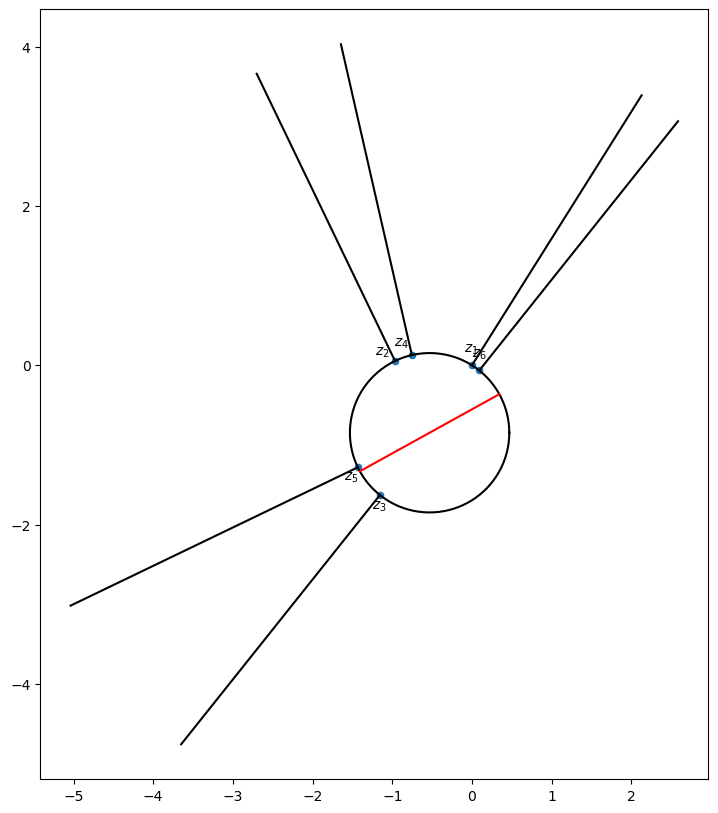

In [322]:
favorite.graph(draw_circle=True)

In [323]:
#shift = favorite.endpoints[0]
#shift_spider(favorite,shift)
z_2_orig = favorite.endpoints[1]
new = update_spider(favorite)
print(favorite.knead)

['A', 'A', 'B', 'A', 'A', 'A']


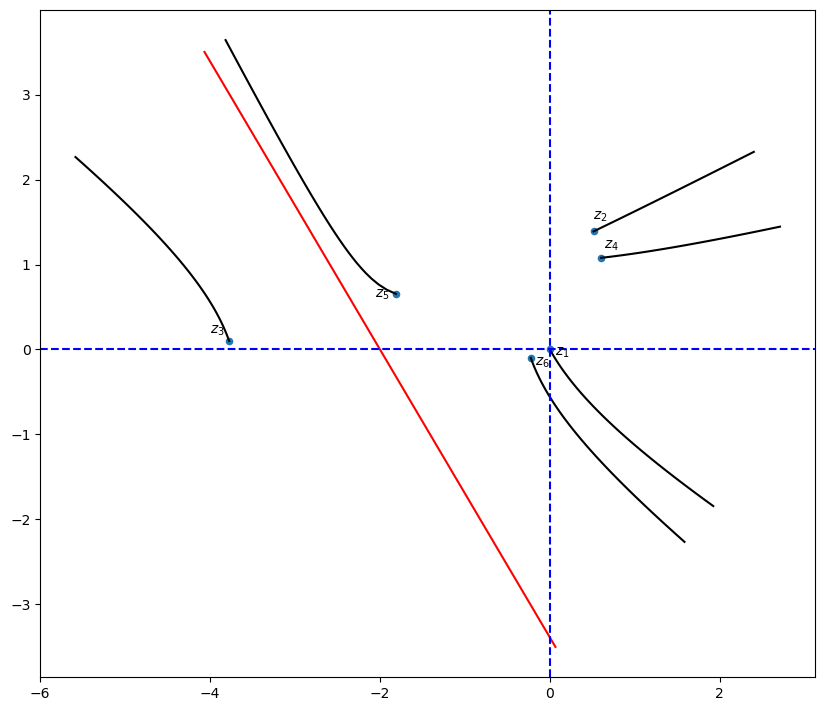

In [324]:
new.graph(draw_axes=True)

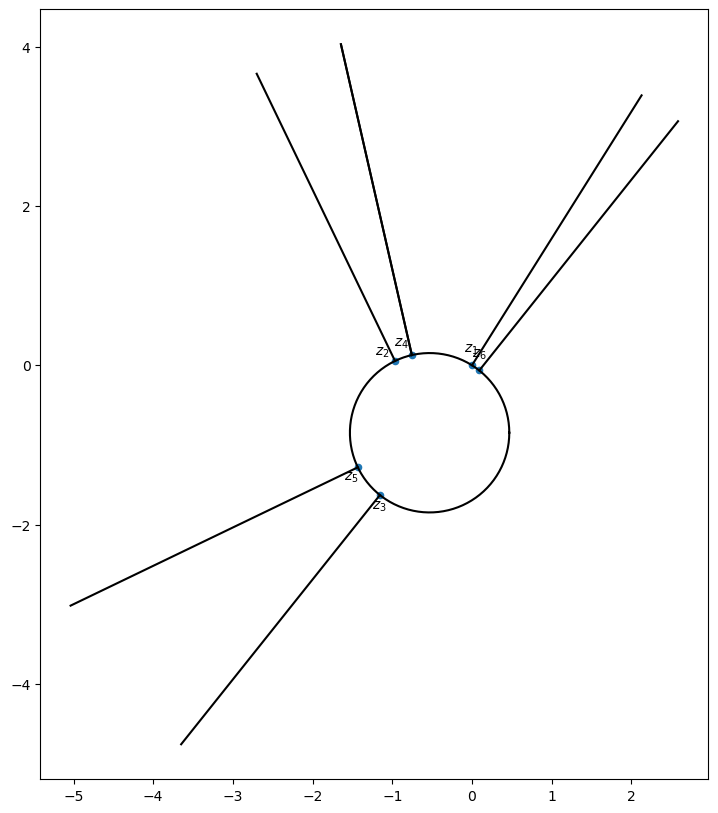

In [349]:
test_spider = Spider(endpoints=np.append(0,z_2_orig*(1+new.endpoints[:-1]/2)**2), legs=z_2_orig*(1+np.append(np.reshape(new.divline[99:],(1,100)),new.legs,axis=0)/2)**2)
#shift_spider(test_spider,-1*shift)
test_spider.graph(True)

In [ ]:
print(test_spider.endpoints)
print(favorite.endpoints+shift)
print(favorite.prelength)

In [348]:
print(np.append(np.reshape(new.divline[99:],(1,100)),new.legs,axis=0).shape)

(7, 100)
